In [2]:
import itertools
import numpy as np
import pandas as pd
import proplot as pplt
import os
import pyproj
import sys
import warnings
import xarray as xr
# sys.path.append('/Users/dwatkin2/Documents/research/packages/buoy_processing/')
sys.path.append('../scripts/')
from scipy.interpolate import interp2d
from drifter import compute_velocity
from drifter import compute_along_across_components
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

#### Specify locations for data.
# External datasets not included in archive are stored in a lower 
# sic_loc = '../../../data/nsidc_daily_cdr/'
# motion_loc = '../../../data/nsidc_daily_icemotion/'
ift_loc = '../data/floe_tracker/ift_with_era5.csv'
df_ift = pd.read_csv(ift_loc, index_col=0)
df_ift.drop('Unnamed: 1', axis=1, inplace=True)
df_ift['datetime'] = pd.to_datetime(df_ift['datetime'].values)
sic = df_ift['sea_ice_concentration']
df_ift.loc[sic > 1, 'sea_ice_concentration'] = np.nan

# Additional filter
# I think I added this into the prep script
speed = np.sqrt(df_ift.loc[df_ift.qc_flag==0, 'u']**2 + df_ift.loc[df_ift.qc_flag==0, 'v']**2)
mean_u = df_ift.loc[df_ift.qc_flag==0, 'u'].mean()
mean_v = df_ift.loc[df_ift.qc_flag==0, 'v'].mean()

z = np.sqrt((df_ift.u - mean_u)**2 + (df_ift.v - mean_v)**2)/np.std(speed)
df_ift.loc[np.abs(z) > 6, 'qc_flag'] = 1
df_filtered = df_ift.loc[df_ift.qc_flag==0]

df_filtered['L'] = np.sqrt(df_filtered['area'])
df_filtered['l_bin'] = np.digitize(df_filtered['L'], bins=np.arange(0, 60, 5))
df_filtered['l_center'] = [pd.Series(np.arange(2.5, 63, 5), index=np.arange(1, 14))[x] for x in df_filtered['l_bin']]
subset = df_filtered.loc[(df_filtered.qc_flag == 0) & df_filtered.zeta.notnull()]

In [15]:
df_cyc = subset.where(subset.zeta > 0).dropna().pivot_table(
    columns='l_center', values='zeta', index='floe_id')
df_anticyc = -subset.where(subset.zeta < 0).dropna().pivot_table(
    columns='l_center', values='zeta', index='floe_id')

idx_cyc = df_cyc.notnull().sum(axis=0) > 100
idx_anticyc = df_anticyc.notnull().sum(axis=0) > 100

df_cyc = df_cyc.loc[:, idx_cyc].copy()
df_anticyc = df_anticyc.loc[:, idx_anticyc].copy()

In [25]:
print(df_cyc.notnull().sum(axis=0))

l_center
2.5      577
7.5     3421
12.5    1115
17.5     375
22.5     131
dtype: int64


In [5]:
sim_rot = pd.read_csv('../data/simulation/rotation_rates.csv')
sim_rot.columns = [c.replace('km', '') for c in sim_rot.columns]
sr_melted = sim_rot.melt()
sr_melted['variable'] = sr_melted['variable'].astype(int)
sr_melted.columns = ['length_scale', 'rotation_rate']
sr_melted['L'] = np.sqrt(np.pi*(sr_melted['length_scale'])**2)

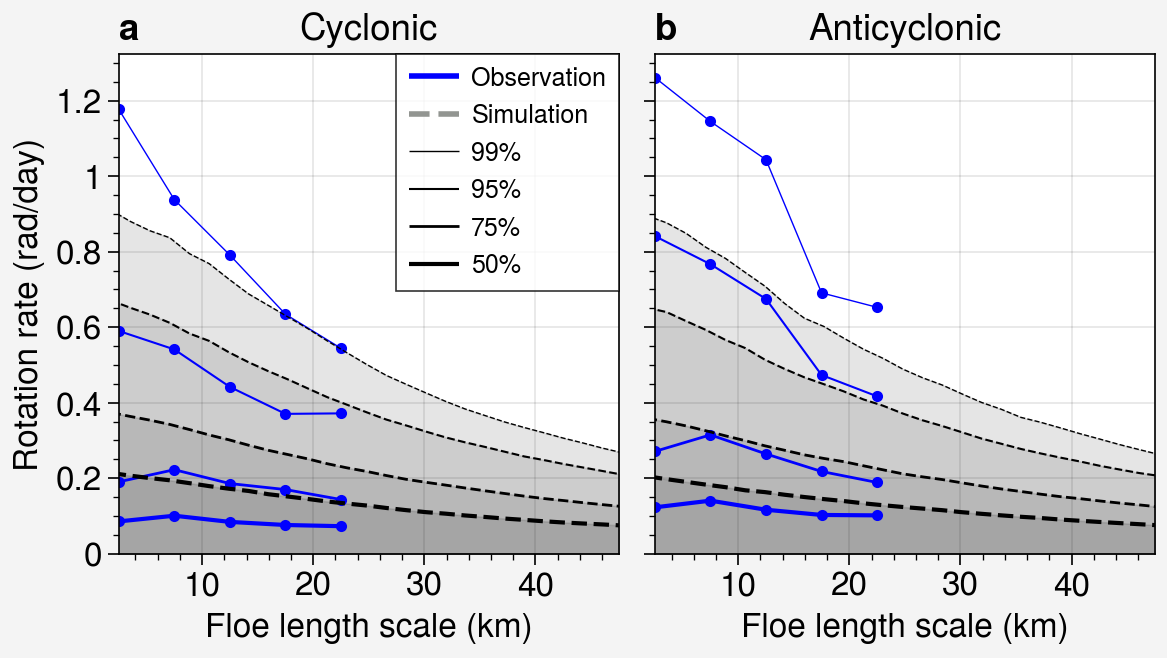

In [27]:
fig, axs = pplt.subplots(ncols=2, sharex=False)
R = sim_rot.where(sim_rot > 0).quantile(0.99, axis=0).interpolate().index.astype(int)
L = np.sqrt(np.pi)*R

for q, lw, m in zip([0.99, 0.95, 0.75, 0.5],
                        [0.5, 0.75, 1, 1.5],
                   ['', '', '', '']):
    

    axs[0].plot(df_cyc.columns, df_cyc.quantile(q, axis=0).interpolate(),
                color='b', lw=lw, marker='.', ls='-')
    axs[1].plot(df_anticyc.columns, df_anticyc.quantile(q, axis=0).interpolate(),
                color='b', lw=lw, ls='-', m='.')

    axs[0].plot(L, sim_rot.where(sim_rot > 0).quantile(q, axis=0).interpolate(),
                color='k', lw=lw, ls='--', marker=m)
    axs[0].area(L, sim_rot.where(sim_rot > 0).quantile(q, axis=0).interpolate(),
               alpha=0.1, color='k')

    
    axs[1].plot(L, (-sim_rot.where(sim_rot < 0)).quantile(q, axis=0).interpolate(),
                color='k', lw=lw, ls='--', marker=m)
    axs[1].area(L, (-sim_rot.where(sim_rot < 0)).quantile(q, axis=0).interpolate(),
               alpha=0.1, color='k')

axs[0].format(xlocator=np.arange(10, 51, 10),
          xlabel='Floe length scale (km)',
           ylabel='Rotation rate (rad/day)', xlim=(2.5, 47.5))
axs[1].format(xlocator=np.arange(10, 51, 10),
          xlabel='Floe length scale (km)',
           ylabel='Rotation rate (rad/day)', xlim=(2.5, 47.5))


axs[0].format(title='Cyclonic')
axs[1].format(title='Anticyclonic')
#     suptitle='Floe rotation rate distribution by length scale',)

# Legend
l = ['Observation', 'Simulation',
     '99%', '95%', '75%', '50%']
h = [axs[0].plot([],[],c=c, lw=lw, m='', ls=ls)
     for c, lw, ls in zip(['b', 'gray', 'k', 'k', 'k', 'k'],
                         [2, 2, 0.5, 0.75, 1, 1.5], ['-', '--', '-', '-', '-', '-'])]
axs[0].legend(h, l, ncols=1)
fig.format(fontsize=12, abc=True)
fig.save('../figures/fig05_rotation_rate_distribution.pdf', dpi=300)

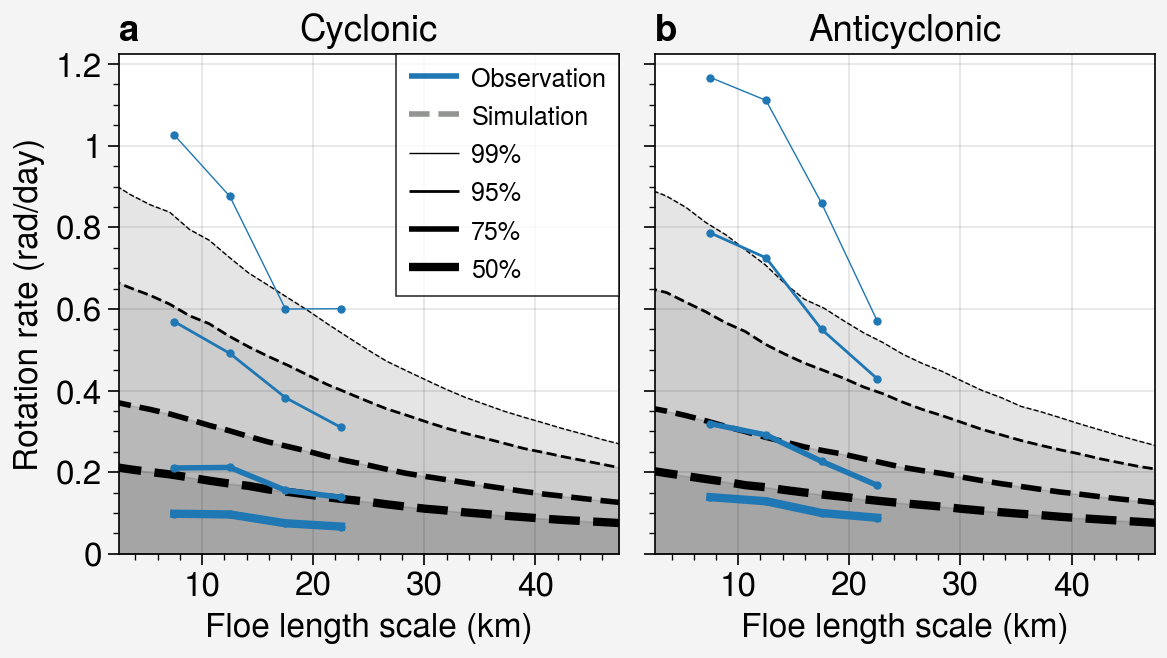

In [1]:
%run ../scripts/08_plot_rotation_dist.py

In [5]:
f = 2*(7.292e-5)*np.sin(np.deg2rad(subset['latitude']))
subset['normalized_rotation'] = subset['zeta']/(f * 24*60*60)
subset['length_scale_km'] = np.sqrt(subset['area_km2'])
df_summary = subset.loc[:, ['l_bin', 'normalized_rotation', 'zeta']].groupby('l_bin').quantile([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])
df_summary.reset_index(inplace=True)
df_summary.columns=['l_bin', 'quantile', 'normalized_rotation', 'zeta']
df_summary_zeta = df_summary.pivot_table(index='l_bin', columns='quantile', values='zeta')
df_summary_omega = df_summary.pivot_table(index='l_bin', columns='quantile', values='normalized_rotation')

x = subset[['l_bin', 'length_scale_km']].groupby('l_bin').median()
df_summary_zeta.index = x.loc[df_summary_zeta.index].values.squeeze()
df_summary_omega.index = x.loc[df_summary_omega.index].values.squeeze()

# The goal of the figure
Previously we show that overall, there is a dependence on length scale. However we know that the sea ice concentration and the distance to the ice edge/coast and the time of year all play a role here.

In [11]:
subset['month'] = subset.datetime.dt.month
subset['year'] = subset.datetime.dt.year

pack_subset = subset.loc[subset.nsidc_sic >= 0.85]
miz_subset = subset.loc[subset.nsidc_sic < 0.85]
miz_subset.groupby('month').count()

,datetime,floe_id,longitude,latitude,x_stere,y_stere,area,perimeter,axis_major_length,axis_minor_length,...,u31D_nsidc,v31D_nsidc,area_adj_km2,L,qc_flag,l_bin,l_center,normalized_rotation,length_scale_km,year
month,,,,,,,,,,,,,,,,,,,,,
4,831,831,831,831,831,831,831,831,831,831,...,786,786,831,831,831,831,831,831,831,831
5,2423,2423,2423,2423,2423,2423,2423,2423,2423,2423,...,2159,2159,2423,2423,2423,2423,2423,2423,2423,2423
6,5609,5609,5609,5609,5609,5609,5609,5609,5609,5609,...,5081,5081,5609,5609,5609,5609,5609,5609,5609,5609
7,1517,1517,1517,1517,1517,1517,1517,1517,1517,1517,...,1375,1375,1517,1517,1517,1517,1517,1517,1517,1517
8,629,629,629,629,629,629,629,629,629,629,...,546,546,629,629,629,629,629,629,629,629
9,104,104,104,104,104,104,104,104,104,104,...,69,69,104,104,104,104,104,104,104,104


In [92]:
pack_counts

l_bin,2,3,4,5,6,7,8,9,10,11,12
month,,,,,,,,,,,
4,6219.0,3842.0,1191.0,510.0,208.0,58.0,38.0,12.0,3.0,4.0,9.0
5,5834.0,3918.0,1278.0,465.0,172.0,106.0,48.0,3.0,5.0,1.0,NaN
6,4688.0,2597.0,745.0,227.0,107.0,32.0,29.0,7.0,2.0,2.0,2.0
7,577.0,266.0,90.0,12.0,6.0,22.0,1.0,NaN,NaN,NaN,NaN
8,200.0,130.0,21.0,12.0,7.0,18.0,1.0,2.0,NaN,NaN,NaN
9,199.0,136.0,27.0,6.0,5.0,4.0,2.0,NaN,NaN,NaN,NaN


In [91]:
miz_counts

l_bin,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,
4,405.0,301.0,73.0,39.0,9.0,NaN,NaN,NaN,2.0,2.0
5,1210.0,823.0,248.0,95.0,22.0,14.0,10.0,1.0,NaN,NaN
6,2881.0,1975.0,512.0,172.0,34.0,17.0,14.0,1.0,2.0,1.0
7,925.0,468.0,89.0,21.0,7.0,6.0,1.0,NaN,NaN,NaN
8,315.0,192.0,86.0,20.0,6.0,9.0,1.0,NaN,NaN,NaN
9,45.0,33.0,16.0,9.0,NaN,1.0,NaN,NaN,NaN,NaN


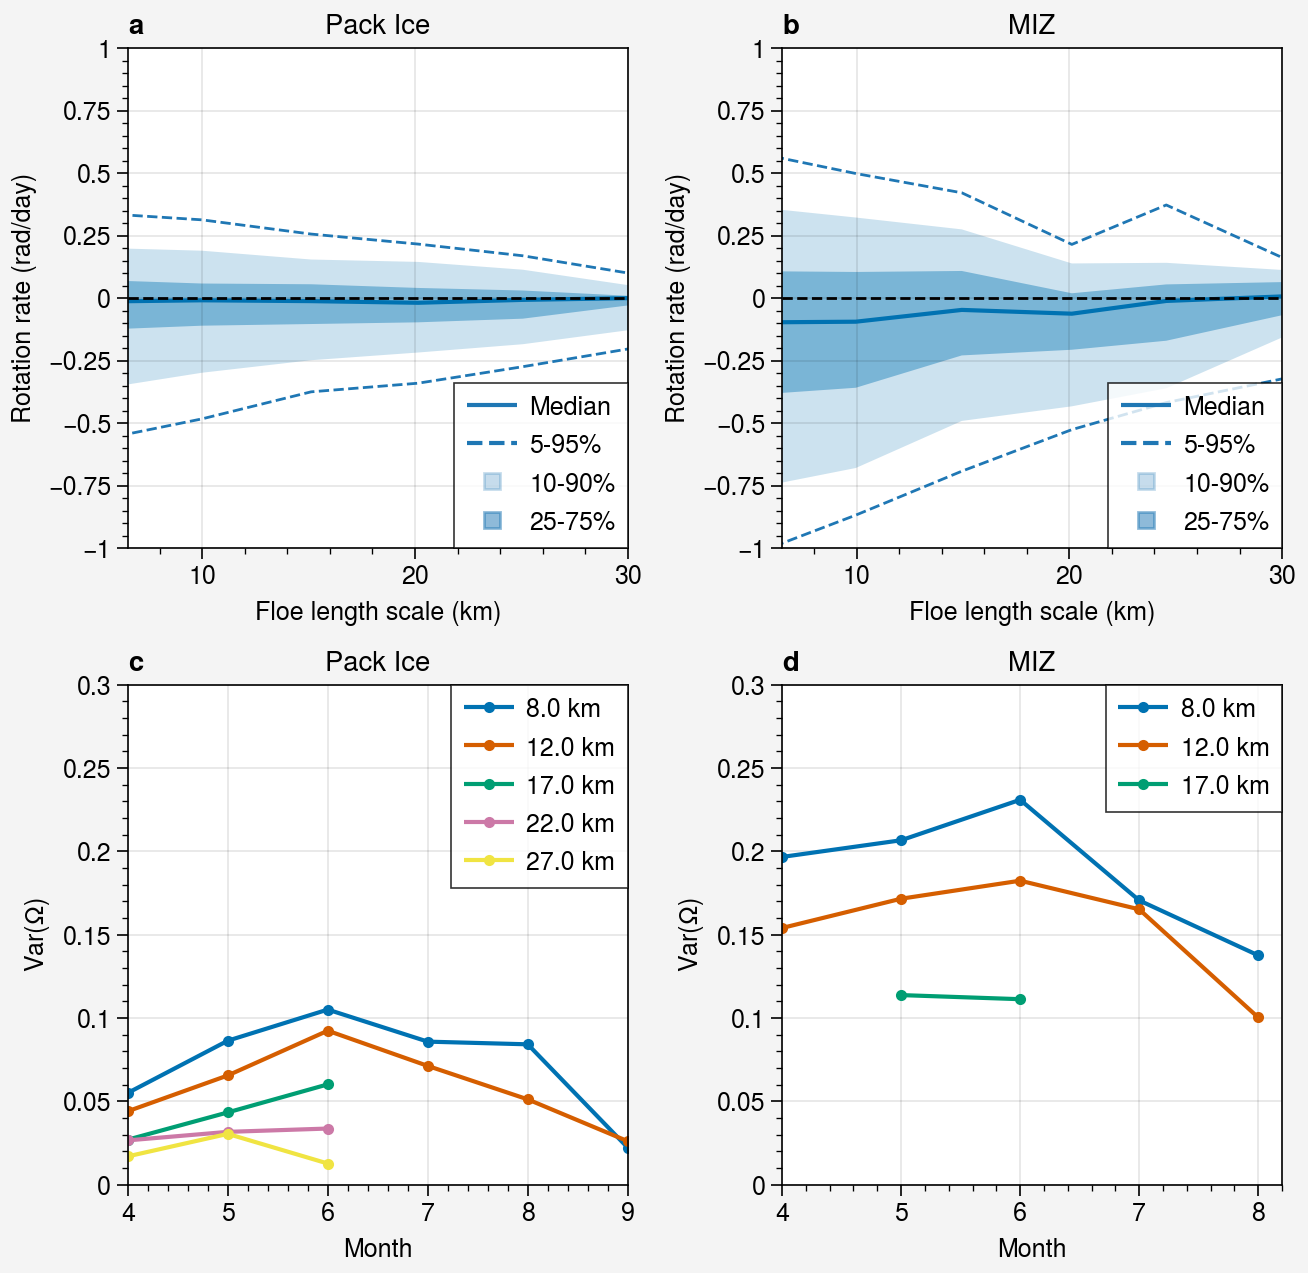

In [90]:
f = 2*(7.292e-5)*np.sin(np.deg2rad(subset['latitude']))
pack_counts = pack_subset.groupby(['month', 'l_bin']).count()['zeta'].reset_index().pivot_table(
    index='month', columns='l_bin', values='zeta')
pack_summary = pack_subset.loc[:, ['l_bin', 'zeta']].groupby('l_bin').quantile([0.05, 0.1, 0.25, 0.5, 0.75, 0.90, 0.95])
pack_summary.reset_index(inplace=True)
pack_summary.columns=['l_bin', 'quantile', 'zeta']
pack_summary = pack_summary.pivot_table(index='l_bin', columns='quantile', values='zeta')

x = pack_subset[['l_bin', 'length_scale_km']].groupby('l_bin').mean()
pack_summary.index = x.loc[pack_summary.index].values.squeeze()

miz_summary = miz_subset.loc[:, ['l_bin', 'zeta']].groupby('l_bin').quantile([0.05, 0.1, 0.25, 0.5, 0.75, 0.90, 0.95])
miz_summary.reset_index(inplace=True)
miz_summary.columns=['l_bin', 'quantile', 'zeta']
miz_summary = miz_summary.pivot_table(index='l_bin', columns='quantile', values='zeta')

x = miz_subset[['l_bin', 'length_scale_km']].groupby('l_bin').mean()
miz_summary.index = x.loc[miz_summary.index].values.squeeze()

fig, axs = pplt.subplots(ncols=2, nrows=2, share=False)
for data, ax in zip([pack_summary, miz_summary], axs[0,:]):
    ax.plot(data[0.05], ls='--', lw=1, color='tab:blue')
    ax.plot(data[0.95], ls='--', lw=1, color='tab:blue')
    
    ax.plot(data[0.5], shadedata=[data[0.25], data[0.75]],
            fadedata=[data[0.1], data[0.9]])
    ax.format(ylabel='Rotation rate (rad/day)', ylim=(-1, 1),
              xlocator=np.arange(10, 31, 10), xlim=(6.5, 30),
              xlabel='Floe length scale (km)')
    ax.axhline(0, color='k', ls='--', lw=1)
for data, ax in zip([pack_subset, miz_subset], axs[1,:]):
    counts = data.groupby(['month', 'l_bin']).count()['zeta'].reset_index().pivot_table(
    index='month', columns='l_bin', values='zeta')

    for bin_num in range(2, 9):
        L = data.loc[data.l_bin==bin_num, 'L'].mean()
        v = data.loc[data.l_bin==bin_num, ['month', 'zeta']].groupby('month').var()
        n = counts[bin_num]
        if sum(n > 100) > 1:
            ax.plot(v.where(n > 100), label=str(np.round(L, 0)) + ' km', marker='.')

    ax.legend(ncols=1, loc='ur')
    ax.format(ylabel='Var($\\Omega$)', xlabel='Month', ylim=(0, 0.3))

h = []
for alpha, ls, m in zip([1, 1, 0.25,  0.5], ['-', '--', '', ''], ['', '', 's', 's']):
    h.append(ax.plot([],[],color='tab:blue', alpha=alpha, ls=ls, m=m))
axs[0,0].legend(h, ['Median',  '5-95%', '10-90%', '25-75%'], ncols=1, loc='lr')
axs[0,1].legend(h, ['Median',  '5-95%', '10-90%', '25-75%'], ncols=1, loc='lr')

axs[0,0].format(title='Pack Ice')
axs[1,0].format(title='Pack Ice')
axs[0,1].format(title='MIZ')
axs[1,1].format(title='MIZ')
axs.format(abc=True)
fig.save('../figures/pdf/figXX_rotation_rate_distribution.pdf', dpi=300)

In [48]:
pack_filtered = pack_subset.groupby(['year', 'month', 'l_bin']).filter(lambda x: len(x) > 30)
pack_month_data = pack_filtered[['year', 'month', 'l_bin', 'zeta']].groupby(['year', 'month', 'l_bin']).var().reset_index()

miz_filtered = miz_subset.groupby(['year', 'month', 'l_bin']).filter(lambda x: len(x) > 30)
miz_month_data = miz_filtered[['year', 'month', 'l_bin', 'zeta']].groupby(['year', 'month', 'l_bin']).var().reset_index()

In [45]:
from scipy.stats import linregress
results = linregress(monthdata.loc[monthdata.month == 4, 'l_bin'], monthdata.loc[monthdata.month == 4, 'zeta'])

4 pack 6.386868131302776e-08
4 miz 0.3329427608674174
5 pack 0.000371470835899794
5 miz 0.0015955418500498472
6 pack 0.022009497425043035
6 miz 2.8356475922754396e-05


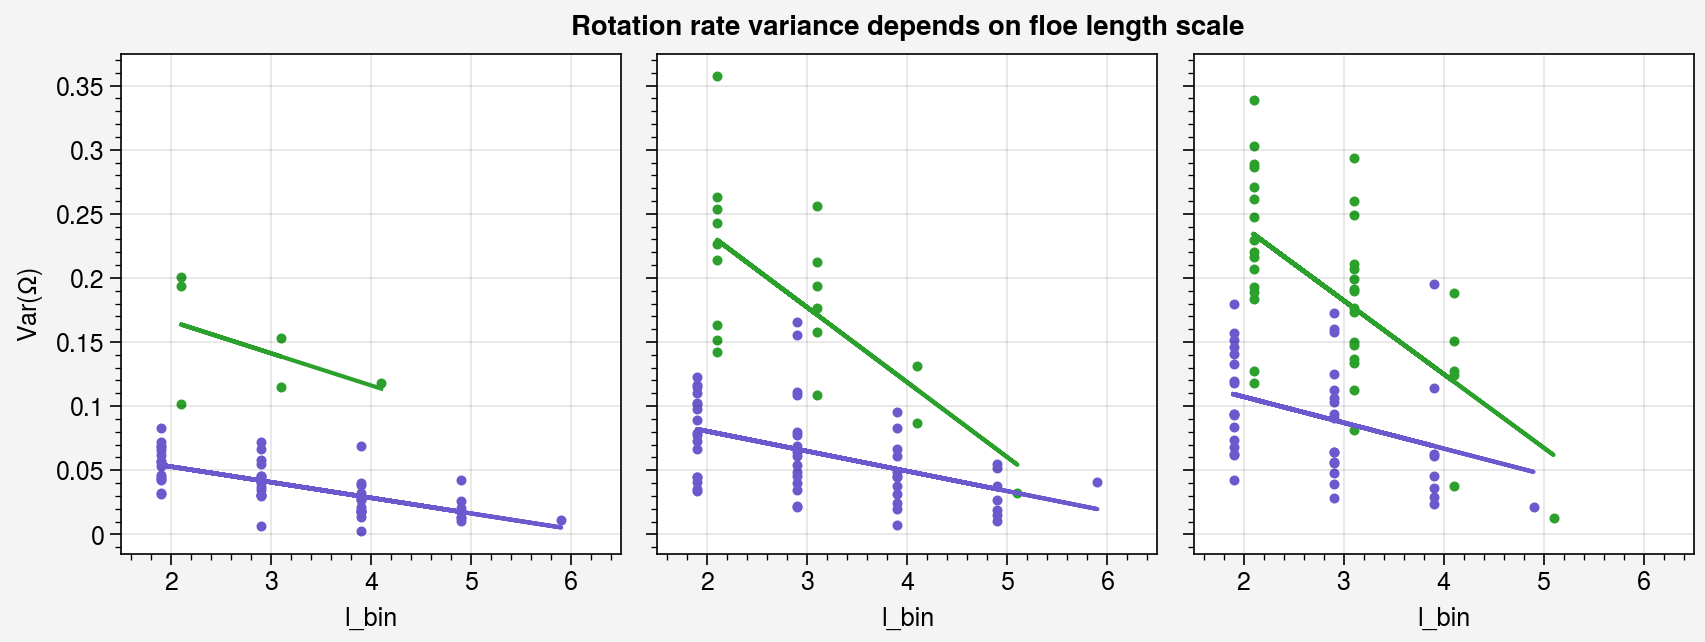

In [57]:
fig, axs = pplt.subplots(ncols=3, sharex=False)
for ax, month in zip(axs, [4, 5, 6]):
    data = pack_month_data.loc[pack_month_data.month == month]
    ax.scatter(data[ 'l_bin']-0.1, data['zeta'], marker='.', color='slateblue')
    results = linregress(data['l_bin'], data['zeta'])
    print(month, 'pack', results.pvalue)
    ax.plot(data['l_bin']-0.1, data['l_bin'] * results.slope + results.intercept, color='slateblue')
    
    data = miz_month_data.loc[miz_month_data.month == month]
    ax.scatter(data[ 'l_bin']+0.1, data['zeta'], marker='.', color='tab:green')
    results = linregress(data['l_bin'], data['zeta'])
    print(month, 'miz', results.pvalue)
    ax.plot(data['l_bin']+0.1, data['l_bin'] * results.slope + results.intercept, color='tab:green')
    ax.format(xlim=(1.5, 6.5))
ax.format(suptitle='Rotation rate variance depends on floe length scale', ylabel='Var($\\Omega$)')

# Potential next step
Taking subsamples of length scale bin, month, and year and resampling to get a better idea of variability in these relationships.

In [69]:
miz_stratified_sample = miz_filtered.groupby(['year', 'month', 'l_bin']).sample(30, replace=False)
pack_stratified_sample = pack_filtered.groupby(['year', 'month', 'l_bin']).sample(30, replace=False)
pack_month_data = pack_stratified_sample[['year', 'month', 'l_bin', 'zeta']].groupby(['year', 'month', 'l_bin']).var().reset_index()
miz_month_data = miz_stratified_sample[['year', 'month', 'l_bin', 'zeta']].groupby(['year', 'month', 'l_bin']).var().reset_index()

4 pack 0.00016714764050023413
4 miz 0.6518967029740833
5 pack 0.006383706627908216
5 miz 0.030462231606364742
6 pack 0.3097375053228517
6 miz 0.007073204185705694


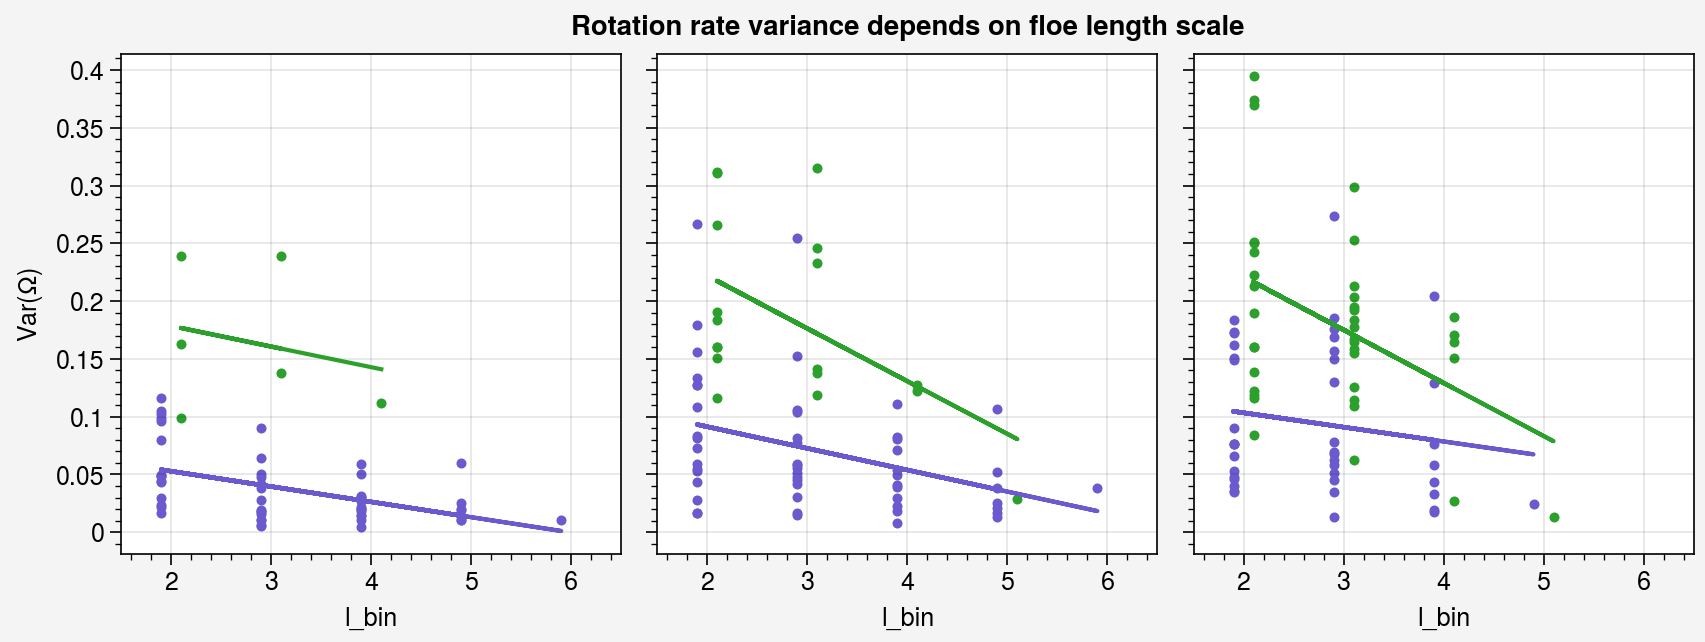

In [70]:
fig, axs = pplt.subplots(ncols=3, sharex=False)
for ax, month in zip(axs, [4, 5, 6]):
    data = pack_month_data.loc[pack_month_data.month == month]
    ax.scatter(data[ 'l_bin']-0.1, data['zeta'], marker='.', color='slateblue')
    results = linregress(data['l_bin'], data['zeta'])
    print(month, 'pack', results.pvalue)
    ax.plot(data['l_bin']-0.1, data['l_bin'] * results.slope + results.intercept, color='slateblue')
    
    data = miz_month_data.loc[miz_month_data.month == month]
    ax.scatter(data[ 'l_bin']+0.1, data['zeta'], marker='.', color='tab:green')
    results = linregress(data['l_bin'], data['zeta'])
    print(month, 'miz', results.pvalue)
    ax.plot(data['l_bin']+0.1, data['l_bin'] * results.slope + results.intercept, color='tab:green')
    ax.format(xlim=(1.5, 6.5))
ax.format(suptitle='Rotation rate variance depends on floe length scale', ylabel='Var($\\Omega$)')